In [9]:
# pip install yfinance matplotlib pandas


# Step 1: yFinance and setting the GRound Rules

### Import required libraries

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

### Function to fetch historical stock data

In [11]:

def fetch_stock_data(ticker, start_date, end_date):
    # Litterally just a shorthand but almost pointless
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


### Function to visualize stock data

In [12]:
def stock_plot(stock_data, ticker):
    # formalise the stock plot 
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Close'], label=f"{ticker} Close Price")
    plt.title(f"{ticker} Stock Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2023-10-02  172.675446  173.222047  169.872879  170.161094  52164500
2023-10-03  171.333786  172.556190  169.763571  171.194652  49594600
2023-10-04  172.586014  173.132615  169.912648  170.031901  53020300
2023-10-05  173.828278  174.364931  171.612058  172.715194  48527900
2023-10-06  176.392334  176.889242  172.108976  172.725152  57224100


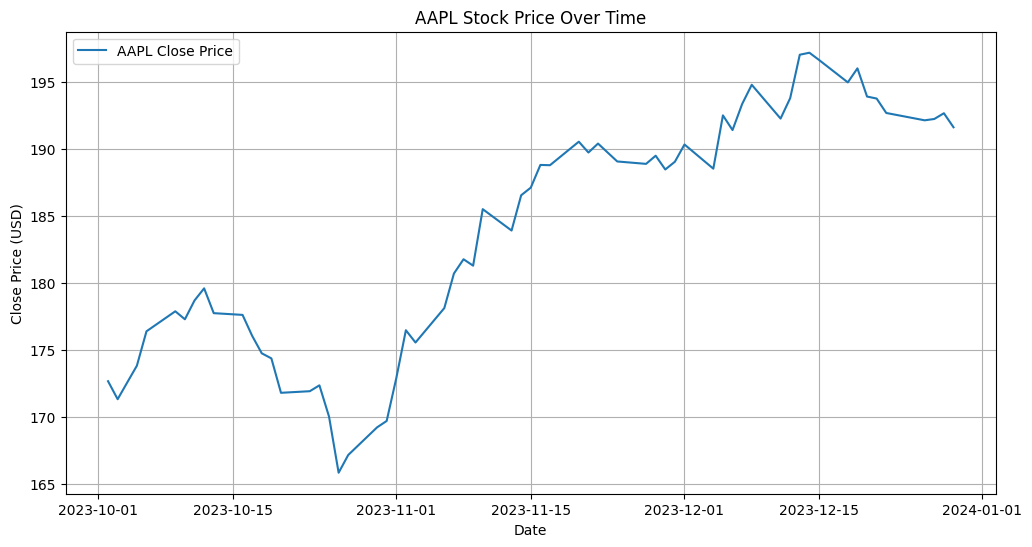

In [38]:
# Example usage
if __name__ == "__main__":
    # Define parameters
    ticker = "AAPL"  # Apple stock
    start_date = "2023-10-01"
    end_date = "2023-12-31"

    # Fetch stock data
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # Display the first few rows
    print(stock_data.head())

    # Visualize the stock data
    stock_plot(stock_data, ticker)


# Step 2: Formalising the Training.
### This can be sub optimal for now as this hopefully will be replaced with later this can be GCP AutoML or something groovey like that.
---
#### Initial Thoughts : 
XGBoost and LSTM are clearly going to perform well here so lets just cut to the chase and when I have a half decent something lets see about using some hyperparamter optimisation going. This bit should be easy but the POC will be using this with an App

---

#### 2.1 More Imports

In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
# hyper param in just grid search not bayseian for now :)
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import tensorflow as tfx

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


### 2.2 Function to Prepare the data

In [ ]:
def prepare_lstm_data(data, target_column, look_back=30):
# Just grab some data and chuck them in X and y 
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

### 2.3 Eg: Grab some AAPL 

In [17]:
# Fetch stock data using the functions
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2023-12-31"
stock_data = fetch_stock_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


### 2.4 PreProcess  Numero 1: Normalise Close

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']].values)

look_back = 30  # Number of days to look back
X, y = prepare_lstm_data(scaled_data, target_column='Close', look_back=look_back)

### 2.5 Admin with the Data

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### 2.6 Define LSTM  

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') # ls and adam 

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))


### 2.7 Visualisation of Model Performance

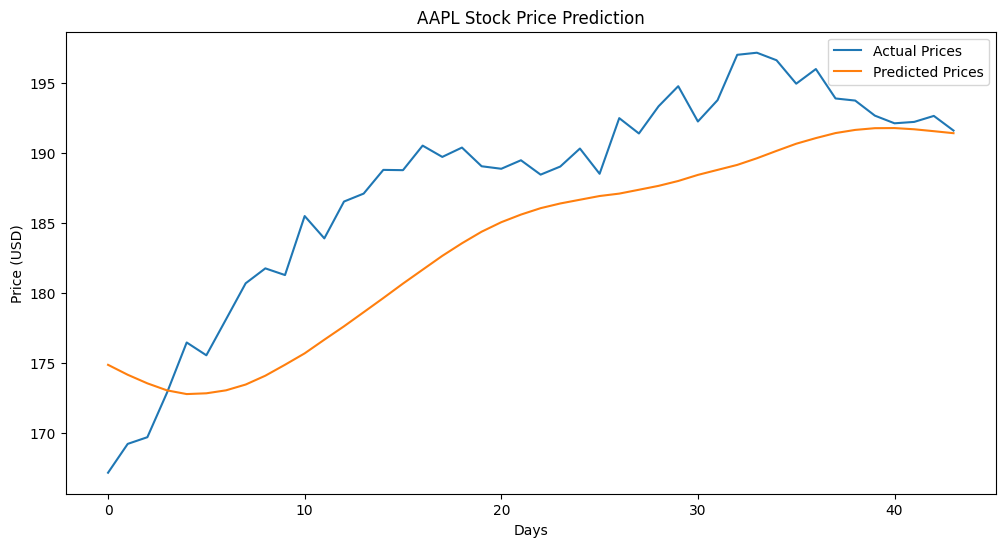

Root Mean Squared Error: 5.595241047174136


In [19]:

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f"Root Mean Squared Error: {rmse}")


Secondary Thoguhts : This serves as a POC, AutoML willl outperform so maybe shouldnt spend too much tiem trying the XGBoost alternative...
But lets try anyway

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2796 - val_loss: 0.0261
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0648 - val_loss: 0.0112
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - val_loss: 0.0701
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0306 - val_loss: 0.0149
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - val_loss: 0.0031
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0085
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - val_loss: 0.0242
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - val_loss: 0.0152
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - val_loss: 0.0122
Epoch 13/20
6/6 ━━━━━━

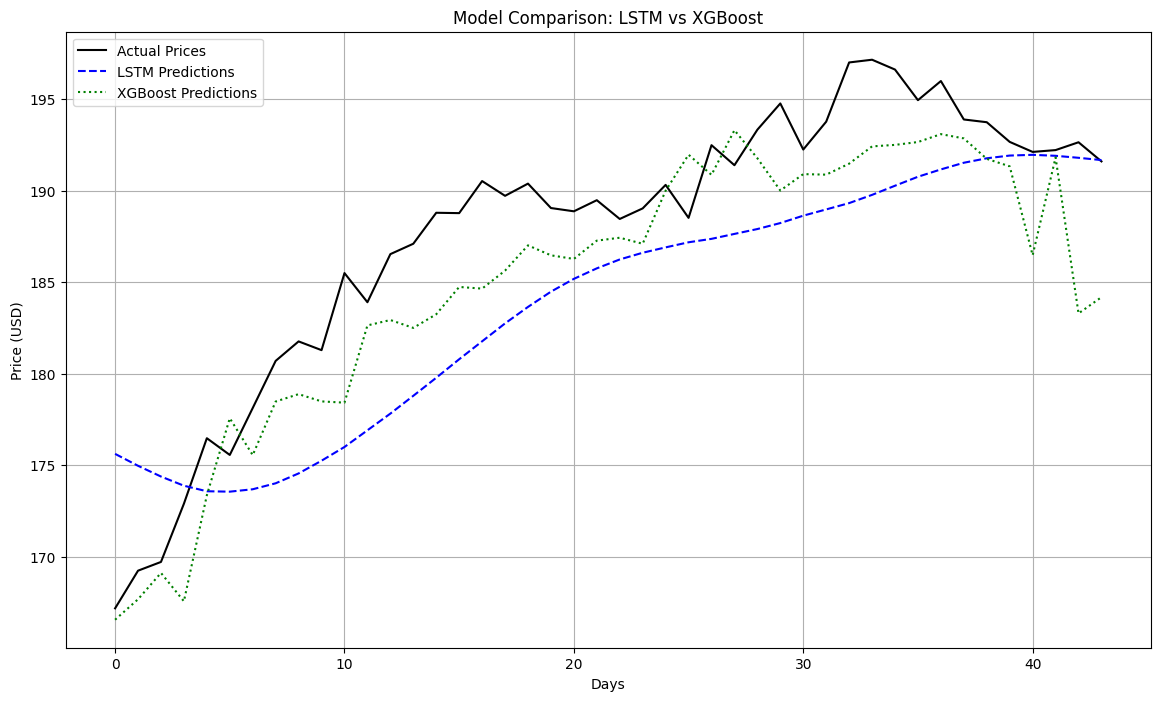

LSTM RMSE: 5.472480657067188
XGBoost RMSE: 3.7226241893711327
The XGBoost model performed better.


In [40]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import tensorflow as tf


# Hyperparameter Optimization for LSTM
def build_lstm_model(units=50, dropout_rate=0.2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(units, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(25))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')  # Loss = MSE
    return model

# Train and Evaluate LSTM
def train_lstm(X_train, y_train, X_test, y_test, units=50, dropout_rate=0.2, epochs=20):
    model = build_lstm_model(units, dropout_rate)
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), verbose=1)
    predictions = model.predict(X_test)
    return model, predictions

# Train and Evaluate XGBoost
def train_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    best_xgb = grid_search.best_estimator_
    predictions = best_xgb.predict(X_test.reshape(X_test.shape[0], -1))
    return best_xgb, predictions

# Train Both Models
lstm_model, lstm_predictions = train_lstm(X_train, y_train, X_test, y_test, units=50, dropout_rate=0.2, epochs=20)
xgb_model, xgb_predictions = train_xgboost(X_train, y_train, X_test, y_test)

# Inverse transform predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Comparison
plt.figure(figsize=(14, 8))
plt.plot(y_test_unscaled, label="Actual Prices", color='black')
plt.plot(lstm_predictions, label="LSTM Predictions", color='blue', linestyle='dashed')
plt.plot(xgb_predictions, label="XGBoost Predictions", color='green', linestyle='dotted')
plt.title("Model Comparison: LSTM vs XGBoost")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

# Evaluate Both Models
from sklearn.metrics import mean_squared_error
lstm_rmse = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))
xgb_rmse = np.sqrt(mean_squared_error(y_test_unscaled, xgb_predictions))

print(f"LSTM RMSE: {lstm_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")

# Choose the Best Model
if lstm_rmse < xgb_rmse:
    print("The LSTM model performed better.")
    best_model = lstm_model
else:
    print("The XGBoost model performed better.")
    best_model = xgb_model
